In [1]:
import numpy as np
import cupy as cp
import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output
from importlib import reload

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('INFO')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

import cgi_phasec_poppy as cgi
from cgi_phasec_poppy import misc

from wfsc import efc_1dm_broad as efc
from wfsc import pwp_1dm as pwp
from wfsc import utils

dm1_flat = 2*fits.getdata(cgi.data_dir/'dm-acts'/'flatmaps'/'hlc_flattened_dm1.fits')
dm2_flat = 2*fits.getdata(cgi.data_dir/'dm-acts'/'flatmaps'/'hlc_flattened_dm2.fits')


INFO:numexpr.utils:Note: detected 96 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 96 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.


In [2]:
nwaves = 3
wavelength_c = 575e-9*u.m
bw = 0.05
wavelengths = np.linspace(wavelength_c*(1-bw/2), wavelength_c*(1+bw/2), nwaves)
wavelengths

<Quantity [5.60625e-07, 5.75000e-07, 5.89375e-07] m>

0.020126611135658824


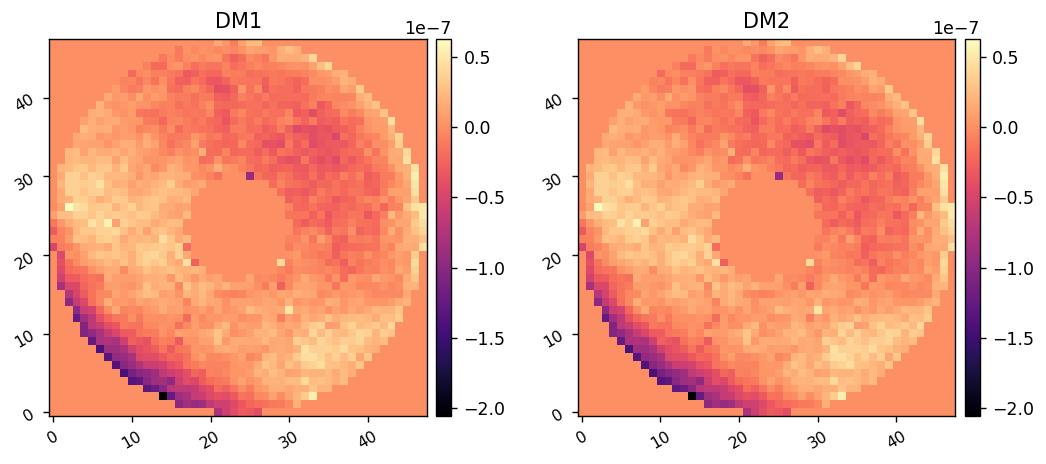

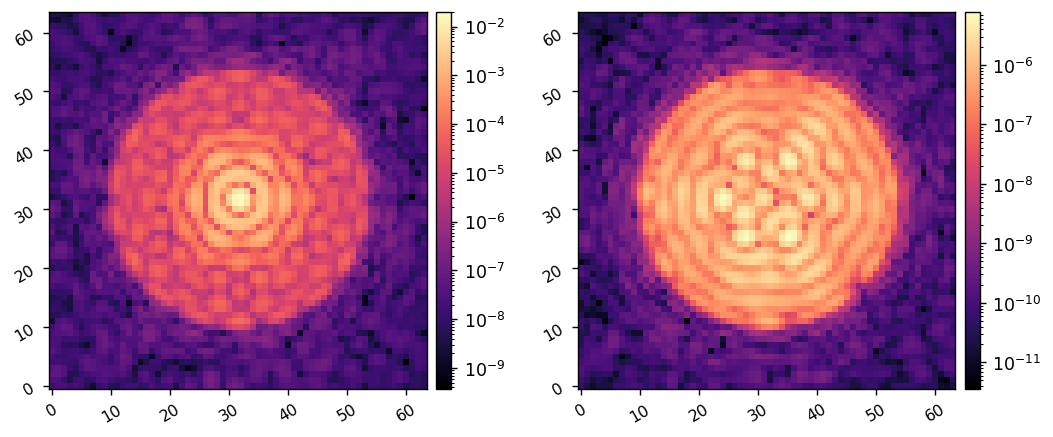

436


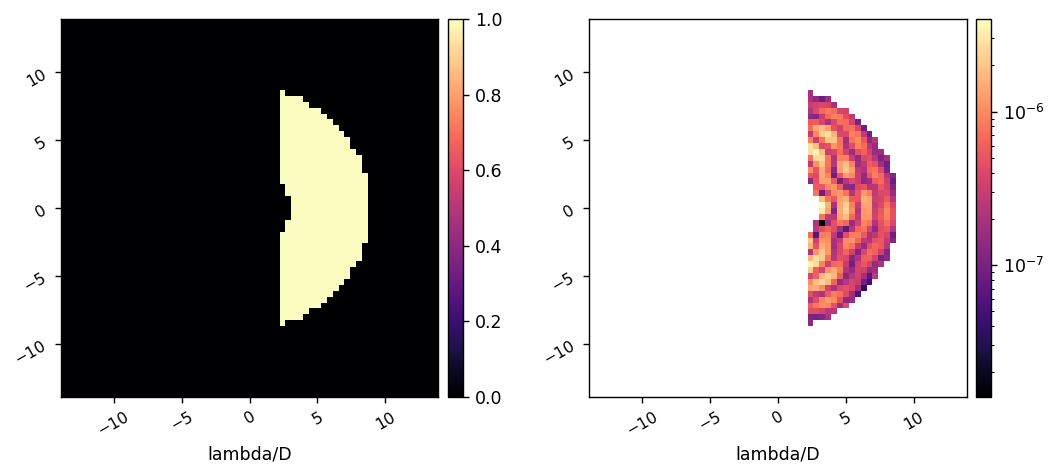

In [3]:
reload(cgi)
sys_unocc = cgi.CGI(cgi_mode='hlc', 
              use_fpm=False,
              use_pupil_defocus=False, 
              polaxis=0,
              use_opds=True,
              dm1_ref=dm1_flat, dm2_ref=dm2_flat,
             )

unocc_psf = 0
for wavelength in wavelengths:
    sys_unocc.wavelength = wavelength
    unocc_psf += sys_unocc.snap()/len(wavelengths)

Imax_unocc = unocc_psf.max()
print(Imax_unocc)

sys = cgi.CGI(cgi_mode='hlc', 
              use_fpm=True,
              use_pupil_defocus=False, 
              polaxis=0,
              use_opds=True,
              dm1_ref=dm1_flat, dm2_ref=dm2_flat,
             )

npsf = sys.npsf
Nact = sys.Nact

ref_psf = 0
for wavelength in wavelengths:
    sys.wavelength = wavelength
    ref_psf += sys.snap()/len(wavelengths)

sys.show_dms()
misc.myimshow2(unocc_psf, ref_psf, lognorm1=True, lognorm2=True)

reload(utils)
xfp = np.linspace(-0.5, 0.5, npsf) * npsf * sys.psf_pixelscale_lamD
xf,yf = np.meshgrid(xfp,xfp)

edge = 2
iwa = 3
owa = 9
rot = 0

# Create the mask that is used to select which region to make dark.
dh_params = {
    'inner_radius' : iwa,
    'outer_radius' : owa,
    'edge_position' : edge,
    'direction' : '+x',
    'rotation':rot,
    'full':False
}
dh_mask = utils.create_annular_focal_plane_mask(xf, yf, dh_params)

nmask = dh_mask.sum()
print(nmask)

misc.myimshow2(dh_mask, ref_psf*dh_mask,  
               pxscl1=sys.psf_pixelscale_lamD, pxscl2=sys.psf_pixelscale_lamD,
               lognorm2=True)

# Create/load Jacobian

In [17]:
reload(efc)

epsilon = 1e-9 # poke amplitudes (DM surface)
jac = efc.build_jacobian(sys, wavelengths, epsilon, dh_mask.flatten(), display=False)

Building Jacobian.
Calculating sensitivity for wavelength 5.606e-07 m
	Calculated response for mode 1/2304. Elapsed time=0.004 sec.
	Calculated response for mode 2/2304. Elapsed time=0.004 sec.
	Calculated response for mode 3/2304. Elapsed time=0.004 sec.
	Calculated response for mode 4/2304. Elapsed time=0.004 sec.
	Calculated response for mode 5/2304. Elapsed time=0.004 sec.
	Calculated response for mode 6/2304. Elapsed time=0.004 sec.
	Calculated response for mode 7/2304. Elapsed time=0.004 sec.
	Calculated response for mode 8/2304. Elapsed time=0.004 sec.
	Calculated response for mode 9/2304. Elapsed time=0.004 sec.
	Calculated response for mode 10/2304. Elapsed time=0.004 sec.
	Calculated response for mode 11/2304. Elapsed time=0.004 sec.
	Calculated response for mode 12/2304. Elapsed time=0.004 sec.
	Calculated response for mode 13/2304. Elapsed time=0.004 sec.
	Calculated response for mode 14/2304. Elapsed time=0.004 sec.
	Calculated response for mode 15/2304. Elapsed time=0.004

	Calculated response for mode 129/2304. Elapsed time=25.654 sec.
	Calculated response for mode 130/2304. Elapsed time=26.278 sec.
	Calculated response for mode 131/2304. Elapsed time=26.278 sec.
	Calculated response for mode 132/2304. Elapsed time=26.279 sec.
	Calculated response for mode 133/2304. Elapsed time=26.279 sec.
	Calculated response for mode 134/2304. Elapsed time=26.279 sec.
	Calculated response for mode 135/2304. Elapsed time=26.279 sec.
	Calculated response for mode 136/2304. Elapsed time=26.279 sec.
	Calculated response for mode 137/2304. Elapsed time=26.279 sec.
	Calculated response for mode 138/2304. Elapsed time=26.279 sec.
	Calculated response for mode 139/2304. Elapsed time=26.279 sec.
	Calculated response for mode 140/2304. Elapsed time=26.279 sec.
	Calculated response for mode 141/2304. Elapsed time=26.279 sec.
	Calculated response for mode 142/2304. Elapsed time=26.279 sec.
	Calculated response for mode 143/2304. Elapsed time=26.279 sec.
	Calculated response for 

	Calculated response for mode 256/2304. Elapsed time=63.430 sec.
	Calculated response for mode 257/2304. Elapsed time=64.055 sec.
	Calculated response for mode 258/2304. Elapsed time=64.679 sec.
	Calculated response for mode 259/2304. Elapsed time=65.305 sec.
	Calculated response for mode 260/2304. Elapsed time=65.931 sec.
	Calculated response for mode 261/2304. Elapsed time=66.563 sec.
	Calculated response for mode 262/2304. Elapsed time=67.188 sec.
	Calculated response for mode 263/2304. Elapsed time=67.812 sec.
	Calculated response for mode 264/2304. Elapsed time=68.439 sec.
	Calculated response for mode 265/2304. Elapsed time=69.065 sec.
	Calculated response for mode 266/2304. Elapsed time=69.689 sec.
	Calculated response for mode 267/2304. Elapsed time=70.316 sec.
	Calculated response for mode 268/2304. Elapsed time=70.942 sec.
	Calculated response for mode 269/2304. Elapsed time=71.577 sec.
	Calculated response for mode 270/2304. Elapsed time=72.202 sec.
	Calculated response for 

	Calculated response for mode 391/2304. Elapsed time=119.894 sec.
	Calculated response for mode 392/2304. Elapsed time=120.517 sec.
	Calculated response for mode 393/2304. Elapsed time=121.147 sec.
	Calculated response for mode 394/2304. Elapsed time=121.775 sec.
	Calculated response for mode 395/2304. Elapsed time=122.400 sec.
	Calculated response for mode 396/2304. Elapsed time=123.029 sec.
	Calculated response for mode 397/2304. Elapsed time=123.655 sec.
	Calculated response for mode 398/2304. Elapsed time=124.281 sec.
	Calculated response for mode 399/2304. Elapsed time=124.905 sec.
	Calculated response for mode 400/2304. Elapsed time=125.530 sec.
	Calculated response for mode 401/2304. Elapsed time=126.157 sec.
	Calculated response for mode 402/2304. Elapsed time=126.786 sec.
	Calculated response for mode 403/2304. Elapsed time=127.412 sec.
	Calculated response for mode 404/2304. Elapsed time=128.036 sec.
	Calculated response for mode 405/2304. Elapsed time=128.663 sec.
	Calculate

	Calculated response for mode 516/2304. Elapsed time=185.689 sec.
	Calculated response for mode 517/2304. Elapsed time=186.314 sec.
	Calculated response for mode 518/2304. Elapsed time=186.941 sec.
	Calculated response for mode 519/2304. Elapsed time=187.566 sec.
	Calculated response for mode 520/2304. Elapsed time=188.192 sec.
	Calculated response for mode 521/2304. Elapsed time=188.817 sec.
	Calculated response for mode 522/2304. Elapsed time=189.443 sec.
	Calculated response for mode 523/2304. Elapsed time=190.070 sec.
	Calculated response for mode 524/2304. Elapsed time=190.695 sec.
	Calculated response for mode 525/2304. Elapsed time=190.695 sec.
	Calculated response for mode 526/2304. Elapsed time=190.695 sec.
	Calculated response for mode 527/2304. Elapsed time=190.695 sec.
	Calculated response for mode 528/2304. Elapsed time=190.695 sec.
	Calculated response for mode 529/2304. Elapsed time=190.695 sec.
	Calculated response for mode 530/2304. Elapsed time=190.695 sec.
	Calculate

	Calculated response for mode 641/2304. Elapsed time=250.971 sec.
	Calculated response for mode 642/2304. Elapsed time=251.596 sec.
	Calculated response for mode 643/2304. Elapsed time=252.219 sec.
	Calculated response for mode 644/2304. Elapsed time=252.842 sec.
	Calculated response for mode 645/2304. Elapsed time=253.464 sec.
	Calculated response for mode 646/2304. Elapsed time=254.088 sec.
	Calculated response for mode 647/2304. Elapsed time=254.715 sec.
	Calculated response for mode 648/2304. Elapsed time=255.339 sec.
	Calculated response for mode 649/2304. Elapsed time=255.964 sec.
	Calculated response for mode 650/2304. Elapsed time=256.591 sec.
	Calculated response for mode 651/2304. Elapsed time=257.218 sec.
	Calculated response for mode 652/2304. Elapsed time=257.844 sec.
	Calculated response for mode 653/2304. Elapsed time=258.469 sec.
	Calculated response for mode 654/2304. Elapsed time=259.092 sec.
	Calculated response for mode 655/2304. Elapsed time=259.719 sec.
	Calculate

	Calculated response for mode 766/2304. Elapsed time=323.598 sec.
	Calculated response for mode 767/2304. Elapsed time=323.599 sec.
	Calculated response for mode 768/2304. Elapsed time=323.599 sec.
	Calculated response for mode 769/2304. Elapsed time=323.599 sec.
	Calculated response for mode 770/2304. Elapsed time=324.225 sec.
	Calculated response for mode 771/2304. Elapsed time=324.848 sec.
	Calculated response for mode 772/2304. Elapsed time=325.475 sec.
	Calculated response for mode 773/2304. Elapsed time=326.098 sec.
	Calculated response for mode 774/2304. Elapsed time=326.720 sec.
	Calculated response for mode 775/2304. Elapsed time=327.346 sec.
	Calculated response for mode 776/2304. Elapsed time=327.971 sec.
	Calculated response for mode 777/2304. Elapsed time=328.596 sec.
	Calculated response for mode 778/2304. Elapsed time=329.226 sec.
	Calculated response for mode 779/2304. Elapsed time=329.853 sec.
	Calculated response for mode 780/2304. Elapsed time=330.480 sec.
	Calculate

	Calculated response for mode 891/2304. Elapsed time=397.469 sec.
	Calculated response for mode 892/2304. Elapsed time=398.083 sec.
	Calculated response for mode 893/2304. Elapsed time=398.696 sec.
	Calculated response for mode 894/2304. Elapsed time=399.312 sec.
	Calculated response for mode 895/2304. Elapsed time=399.927 sec.
	Calculated response for mode 896/2304. Elapsed time=400.543 sec.
	Calculated response for mode 897/2304. Elapsed time=401.160 sec.
	Calculated response for mode 898/2304. Elapsed time=401.776 sec.
	Calculated response for mode 899/2304. Elapsed time=402.394 sec.
	Calculated response for mode 900/2304. Elapsed time=403.010 sec.
	Calculated response for mode 901/2304. Elapsed time=403.629 sec.
	Calculated response for mode 902/2304. Elapsed time=404.250 sec.
	Calculated response for mode 903/2304. Elapsed time=404.866 sec.
	Calculated response for mode 904/2304. Elapsed time=405.482 sec.
	Calculated response for mode 905/2304. Elapsed time=406.098 sec.
	Calculate

	Calculated response for mode 1015/2304. Elapsed time=471.602 sec.
	Calculated response for mode 1016/2304. Elapsed time=472.226 sec.
	Calculated response for mode 1017/2304. Elapsed time=472.856 sec.
	Calculated response for mode 1018/2304. Elapsed time=473.481 sec.
	Calculated response for mode 1019/2304. Elapsed time=474.106 sec.
	Calculated response for mode 1020/2304. Elapsed time=474.730 sec.
	Calculated response for mode 1021/2304. Elapsed time=475.356 sec.
	Calculated response for mode 1022/2304. Elapsed time=475.980 sec.
	Calculated response for mode 1023/2304. Elapsed time=476.600 sec.
	Calculated response for mode 1024/2304. Elapsed time=477.221 sec.
	Calculated response for mode 1025/2304. Elapsed time=477.845 sec.
	Calculated response for mode 1026/2304. Elapsed time=478.468 sec.
	Calculated response for mode 1027/2304. Elapsed time=479.096 sec.
	Calculated response for mode 1028/2304. Elapsed time=479.718 sec.
	Calculated response for mode 1029/2304. Elapsed time=480.344 

	Calculated response for mode 1138/2304. Elapsed time=548.747 sec.
	Calculated response for mode 1139/2304. Elapsed time=549.376 sec.
	Calculated response for mode 1140/2304. Elapsed time=550.002 sec.
	Calculated response for mode 1141/2304. Elapsed time=550.626 sec.
	Calculated response for mode 1142/2304. Elapsed time=551.252 sec.
	Calculated response for mode 1143/2304. Elapsed time=551.878 sec.
	Calculated response for mode 1144/2304. Elapsed time=552.504 sec.
	Calculated response for mode 1145/2304. Elapsed time=553.127 sec.
	Calculated response for mode 1146/2304. Elapsed time=553.756 sec.
	Calculated response for mode 1147/2304. Elapsed time=554.380 sec.
	Calculated response for mode 1148/2304. Elapsed time=555.003 sec.
	Calculated response for mode 1149/2304. Elapsed time=555.629 sec.
	Calculated response for mode 1150/2304. Elapsed time=556.249 sec.
	Calculated response for mode 1151/2304. Elapsed time=556.875 sec.
	Calculated response for mode 1152/2304. Elapsed time=557.498 

	Calculated response for mode 1261/2304. Elapsed time=625.684 sec.
	Calculated response for mode 1262/2304. Elapsed time=626.308 sec.
	Calculated response for mode 1263/2304. Elapsed time=626.929 sec.
	Calculated response for mode 1264/2304. Elapsed time=627.552 sec.
	Calculated response for mode 1265/2304. Elapsed time=628.178 sec.
	Calculated response for mode 1266/2304. Elapsed time=628.801 sec.
	Calculated response for mode 1267/2304. Elapsed time=629.424 sec.
	Calculated response for mode 1268/2304. Elapsed time=630.047 sec.
	Calculated response for mode 1269/2304. Elapsed time=630.671 sec.
	Calculated response for mode 1270/2304. Elapsed time=631.296 sec.
	Calculated response for mode 1271/2304. Elapsed time=631.921 sec.
	Calculated response for mode 1272/2304. Elapsed time=632.544 sec.
	Calculated response for mode 1273/2304. Elapsed time=633.168 sec.
	Calculated response for mode 1274/2304. Elapsed time=633.793 sec.
	Calculated response for mode 1275/2304. Elapsed time=634.417 

	Calculated response for mode 1384/2304. Elapsed time=700.903 sec.
	Calculated response for mode 1385/2304. Elapsed time=701.528 sec.
	Calculated response for mode 1386/2304. Elapsed time=702.154 sec.
	Calculated response for mode 1387/2304. Elapsed time=702.779 sec.
	Calculated response for mode 1388/2304. Elapsed time=703.403 sec.
	Calculated response for mode 1389/2304. Elapsed time=704.027 sec.
	Calculated response for mode 1390/2304. Elapsed time=704.653 sec.
	Calculated response for mode 1391/2304. Elapsed time=705.276 sec.
	Calculated response for mode 1392/2304. Elapsed time=705.276 sec.
	Calculated response for mode 1393/2304. Elapsed time=705.277 sec.
	Calculated response for mode 1394/2304. Elapsed time=705.904 sec.
	Calculated response for mode 1395/2304. Elapsed time=706.527 sec.
	Calculated response for mode 1396/2304. Elapsed time=707.151 sec.
	Calculated response for mode 1397/2304. Elapsed time=707.775 sec.
	Calculated response for mode 1398/2304. Elapsed time=708.399 

	Calculated response for mode 1507/2304. Elapsed time=773.864 sec.
	Calculated response for mode 1508/2304. Elapsed time=774.484 sec.
	Calculated response for mode 1509/2304. Elapsed time=775.108 sec.
	Calculated response for mode 1510/2304. Elapsed time=775.732 sec.
	Calculated response for mode 1511/2304. Elapsed time=776.357 sec.
	Calculated response for mode 1512/2304. Elapsed time=776.981 sec.
	Calculated response for mode 1513/2304. Elapsed time=777.606 sec.
	Calculated response for mode 1514/2304. Elapsed time=778.230 sec.
	Calculated response for mode 1515/2304. Elapsed time=778.853 sec.
	Calculated response for mode 1516/2304. Elapsed time=779.476 sec.
	Calculated response for mode 1517/2304. Elapsed time=780.099 sec.
	Calculated response for mode 1518/2304. Elapsed time=780.721 sec.
	Calculated response for mode 1519/2304. Elapsed time=781.342 sec.
	Calculated response for mode 1520/2304. Elapsed time=781.962 sec.
	Calculated response for mode 1521/2304. Elapsed time=782.587 

	Calculated response for mode 1630/2304. Elapsed time=846.557 sec.
	Calculated response for mode 1631/2304. Elapsed time=846.557 sec.
	Calculated response for mode 1632/2304. Elapsed time=846.558 sec.
	Calculated response for mode 1633/2304. Elapsed time=846.558 sec.
	Calculated response for mode 1634/2304. Elapsed time=846.558 sec.
	Calculated response for mode 1635/2304. Elapsed time=846.558 sec.
	Calculated response for mode 1636/2304. Elapsed time=847.185 sec.
	Calculated response for mode 1637/2304. Elapsed time=847.809 sec.
	Calculated response for mode 1638/2304. Elapsed time=848.432 sec.
	Calculated response for mode 1639/2304. Elapsed time=849.057 sec.
	Calculated response for mode 1640/2304. Elapsed time=849.678 sec.
	Calculated response for mode 1641/2304. Elapsed time=850.300 sec.
	Calculated response for mode 1642/2304. Elapsed time=850.922 sec.
	Calculated response for mode 1643/2304. Elapsed time=851.545 sec.
	Calculated response for mode 1644/2304. Elapsed time=852.167 

	Calculated response for mode 1753/2304. Elapsed time=912.048 sec.
	Calculated response for mode 1754/2304. Elapsed time=912.670 sec.
	Calculated response for mode 1755/2304. Elapsed time=913.289 sec.
	Calculated response for mode 1756/2304. Elapsed time=913.987 sec.
	Calculated response for mode 1757/2304. Elapsed time=914.610 sec.
	Calculated response for mode 1758/2304. Elapsed time=915.232 sec.
	Calculated response for mode 1759/2304. Elapsed time=915.855 sec.
	Calculated response for mode 1760/2304. Elapsed time=916.479 sec.
	Calculated response for mode 1761/2304. Elapsed time=917.103 sec.
	Calculated response for mode 1762/2304. Elapsed time=917.725 sec.
	Calculated response for mode 1763/2304. Elapsed time=918.352 sec.
	Calculated response for mode 1764/2304. Elapsed time=918.978 sec.
	Calculated response for mode 1765/2304. Elapsed time=919.599 sec.
	Calculated response for mode 1766/2304. Elapsed time=920.223 sec.
	Calculated response for mode 1767/2304. Elapsed time=920.847 

	Calculated response for mode 1879/2304. Elapsed time=973.319 sec.
	Calculated response for mode 1880/2304. Elapsed time=973.941 sec.
	Calculated response for mode 1881/2304. Elapsed time=974.566 sec.
	Calculated response for mode 1882/2304. Elapsed time=975.192 sec.
	Calculated response for mode 1883/2304. Elapsed time=975.813 sec.
	Calculated response for mode 1884/2304. Elapsed time=976.435 sec.
	Calculated response for mode 1885/2304. Elapsed time=977.061 sec.
	Calculated response for mode 1886/2304. Elapsed time=977.683 sec.
	Calculated response for mode 1887/2304. Elapsed time=978.303 sec.
	Calculated response for mode 1888/2304. Elapsed time=978.926 sec.
	Calculated response for mode 1889/2304. Elapsed time=979.550 sec.
	Calculated response for mode 1890/2304. Elapsed time=980.171 sec.
	Calculated response for mode 1891/2304. Elapsed time=980.793 sec.
	Calculated response for mode 1892/2304. Elapsed time=981.413 sec.
	Calculated response for mode 1893/2304. Elapsed time=982.035 

	Calculated response for mode 2001/2304. Elapsed time=1031.817 sec.
	Calculated response for mode 2002/2304. Elapsed time=1032.439 sec.
	Calculated response for mode 2003/2304. Elapsed time=1033.060 sec.
	Calculated response for mode 2004/2304. Elapsed time=1033.684 sec.
	Calculated response for mode 2005/2304. Elapsed time=1034.304 sec.
	Calculated response for mode 2006/2304. Elapsed time=1034.925 sec.
	Calculated response for mode 2007/2304. Elapsed time=1035.547 sec.
	Calculated response for mode 2008/2304. Elapsed time=1036.169 sec.
	Calculated response for mode 2009/2304. Elapsed time=1036.170 sec.
	Calculated response for mode 2010/2304. Elapsed time=1036.170 sec.
	Calculated response for mode 2011/2304. Elapsed time=1036.170 sec.
	Calculated response for mode 2012/2304. Elapsed time=1036.170 sec.
	Calculated response for mode 2013/2304. Elapsed time=1036.170 sec.
	Calculated response for mode 2014/2304. Elapsed time=1036.170 sec.
	Calculated response for mode 2015/2304. Elapsed

	Calculated response for mode 2125/2304. Elapsed time=1072.960 sec.
	Calculated response for mode 2126/2304. Elapsed time=1073.581 sec.
	Calculated response for mode 2127/2304. Elapsed time=1074.202 sec.
	Calculated response for mode 2128/2304. Elapsed time=1074.824 sec.
	Calculated response for mode 2129/2304. Elapsed time=1075.444 sec.
	Calculated response for mode 2130/2304. Elapsed time=1076.068 sec.
	Calculated response for mode 2131/2304. Elapsed time=1076.691 sec.
	Calculated response for mode 2132/2304. Elapsed time=1077.314 sec.
	Calculated response for mode 2133/2304. Elapsed time=1077.937 sec.
	Calculated response for mode 2134/2304. Elapsed time=1078.559 sec.
	Calculated response for mode 2135/2304. Elapsed time=1079.180 sec.
	Calculated response for mode 2136/2304. Elapsed time=1079.807 sec.
	Calculated response for mode 2137/2304. Elapsed time=1080.431 sec.
	Calculated response for mode 2138/2304. Elapsed time=1081.055 sec.
	Calculated response for mode 2139/2304. Elapsed

	Calculated response for mode 2278/2304. Elapsed time=1110.410 sec.
	Calculated response for mode 2279/2304. Elapsed time=1111.030 sec.
	Calculated response for mode 2280/2304. Elapsed time=1111.649 sec.
	Calculated response for mode 2281/2304. Elapsed time=1112.269 sec.
	Calculated response for mode 2282/2304. Elapsed time=1112.890 sec.
	Calculated response for mode 2283/2304. Elapsed time=1113.511 sec.
	Calculated response for mode 2284/2304. Elapsed time=1113.511 sec.
	Calculated response for mode 2285/2304. Elapsed time=1113.511 sec.
	Calculated response for mode 2286/2304. Elapsed time=1113.511 sec.
	Calculated response for mode 2287/2304. Elapsed time=1113.511 sec.
	Calculated response for mode 2288/2304. Elapsed time=1113.511 sec.
	Calculated response for mode 2289/2304. Elapsed time=1113.511 sec.
	Calculated response for mode 2290/2304. Elapsed time=1113.511 sec.
	Calculated response for mode 2291/2304. Elapsed time=1113.511 sec.
	Calculated response for mode 2292/2304. Elapsed

	Calculated response for mode 111/2304. Elapsed time=1127.783 sec.
	Calculated response for mode 112/2304. Elapsed time=1128.403 sec.
	Calculated response for mode 113/2304. Elapsed time=1129.022 sec.
	Calculated response for mode 114/2304. Elapsed time=1129.642 sec.
	Calculated response for mode 115/2304. Elapsed time=1130.261 sec.
	Calculated response for mode 116/2304. Elapsed time=1130.884 sec.
	Calculated response for mode 117/2304. Elapsed time=1131.504 sec.
	Calculated response for mode 118/2304. Elapsed time=1132.126 sec.
	Calculated response for mode 119/2304. Elapsed time=1132.747 sec.
	Calculated response for mode 120/2304. Elapsed time=1133.372 sec.
	Calculated response for mode 121/2304. Elapsed time=1133.994 sec.
	Calculated response for mode 122/2304. Elapsed time=1134.614 sec.
	Calculated response for mode 123/2304. Elapsed time=1135.237 sec.
	Calculated response for mode 124/2304. Elapsed time=1135.983 sec.
	Calculated response for mode 125/2304. Elapsed time=1136.607 

	Calculated response for mode 250/2304. Elapsed time=1172.675 sec.
	Calculated response for mode 251/2304. Elapsed time=1173.299 sec.
	Calculated response for mode 252/2304. Elapsed time=1173.920 sec.
	Calculated response for mode 253/2304. Elapsed time=1174.543 sec.
	Calculated response for mode 254/2304. Elapsed time=1175.167 sec.
	Calculated response for mode 255/2304. Elapsed time=1175.788 sec.
	Calculated response for mode 256/2304. Elapsed time=1176.411 sec.
	Calculated response for mode 257/2304. Elapsed time=1177.036 sec.
	Calculated response for mode 258/2304. Elapsed time=1177.659 sec.
	Calculated response for mode 259/2304. Elapsed time=1178.281 sec.
	Calculated response for mode 260/2304. Elapsed time=1178.904 sec.
	Calculated response for mode 261/2304. Elapsed time=1179.525 sec.
	Calculated response for mode 262/2304. Elapsed time=1180.147 sec.
	Calculated response for mode 263/2304. Elapsed time=1180.769 sec.
	Calculated response for mode 264/2304. Elapsed time=1181.390 

	Calculated response for mode 373/2304. Elapsed time=1229.443 sec.
	Calculated response for mode 374/2304. Elapsed time=1230.067 sec.
	Calculated response for mode 375/2304. Elapsed time=1230.690 sec.
	Calculated response for mode 376/2304. Elapsed time=1231.313 sec.
	Calculated response for mode 377/2304. Elapsed time=1231.933 sec.
	Calculated response for mode 378/2304. Elapsed time=1231.933 sec.
	Calculated response for mode 379/2304. Elapsed time=1231.933 sec.
	Calculated response for mode 380/2304. Elapsed time=1231.933 sec.
	Calculated response for mode 381/2304. Elapsed time=1231.933 sec.
	Calculated response for mode 382/2304. Elapsed time=1231.933 sec.
	Calculated response for mode 383/2304. Elapsed time=1231.933 sec.
	Calculated response for mode 384/2304. Elapsed time=1231.933 sec.
	Calculated response for mode 385/2304. Elapsed time=1231.933 sec.
	Calculated response for mode 386/2304. Elapsed time=1231.933 sec.
	Calculated response for mode 387/2304. Elapsed time=1231.933 

	Calculated response for mode 496/2304. Elapsed time=1285.592 sec.
	Calculated response for mode 497/2304. Elapsed time=1286.216 sec.
	Calculated response for mode 498/2304. Elapsed time=1286.959 sec.
	Calculated response for mode 499/2304. Elapsed time=1287.580 sec.
	Calculated response for mode 500/2304. Elapsed time=1288.204 sec.
	Calculated response for mode 501/2304. Elapsed time=1288.824 sec.
	Calculated response for mode 502/2304. Elapsed time=1289.446 sec.
	Calculated response for mode 503/2304. Elapsed time=1290.069 sec.
	Calculated response for mode 504/2304. Elapsed time=1290.690 sec.
	Calculated response for mode 505/2304. Elapsed time=1291.312 sec.
	Calculated response for mode 506/2304. Elapsed time=1291.935 sec.
	Calculated response for mode 507/2304. Elapsed time=1292.557 sec.
	Calculated response for mode 508/2304. Elapsed time=1293.179 sec.
	Calculated response for mode 509/2304. Elapsed time=1293.803 sec.
	Calculated response for mode 510/2304. Elapsed time=1294.425 

	Calculated response for mode 619/2304. Elapsed time=1353.030 sec.
	Calculated response for mode 620/2304. Elapsed time=1353.653 sec.
	Calculated response for mode 621/2304. Elapsed time=1354.272 sec.
	Calculated response for mode 622/2304. Elapsed time=1354.273 sec.
	Calculated response for mode 623/2304. Elapsed time=1354.273 sec.
	Calculated response for mode 624/2304. Elapsed time=1354.273 sec.
	Calculated response for mode 625/2304. Elapsed time=1354.273 sec.
	Calculated response for mode 626/2304. Elapsed time=1354.273 sec.
	Calculated response for mode 627/2304. Elapsed time=1354.273 sec.
	Calculated response for mode 628/2304. Elapsed time=1354.894 sec.
	Calculated response for mode 629/2304. Elapsed time=1355.518 sec.
	Calculated response for mode 630/2304. Elapsed time=1356.142 sec.
	Calculated response for mode 631/2304. Elapsed time=1356.764 sec.
	Calculated response for mode 632/2304. Elapsed time=1357.384 sec.
	Calculated response for mode 633/2304. Elapsed time=1358.004 

	Calculated response for mode 742/2304. Elapsed time=1420.208 sec.
	Calculated response for mode 743/2304. Elapsed time=1420.827 sec.
	Calculated response for mode 744/2304. Elapsed time=1421.446 sec.
	Calculated response for mode 745/2304. Elapsed time=1422.067 sec.
	Calculated response for mode 746/2304. Elapsed time=1422.687 sec.
	Calculated response for mode 747/2304. Elapsed time=1423.306 sec.
	Calculated response for mode 748/2304. Elapsed time=1423.926 sec.
	Calculated response for mode 749/2304. Elapsed time=1424.546 sec.
	Calculated response for mode 750/2304. Elapsed time=1425.166 sec.
	Calculated response for mode 751/2304. Elapsed time=1425.788 sec.
	Calculated response for mode 752/2304. Elapsed time=1426.413 sec.
	Calculated response for mode 753/2304. Elapsed time=1427.034 sec.
	Calculated response for mode 754/2304. Elapsed time=1427.656 sec.
	Calculated response for mode 755/2304. Elapsed time=1428.278 sec.
	Calculated response for mode 756/2304. Elapsed time=1428.897 

	Calculated response for mode 866/2304. Elapsed time=1493.072 sec.
	Calculated response for mode 867/2304. Elapsed time=1493.696 sec.
	Calculated response for mode 868/2304. Elapsed time=1494.317 sec.
	Calculated response for mode 869/2304. Elapsed time=1494.939 sec.
	Calculated response for mode 870/2304. Elapsed time=1495.564 sec.
	Calculated response for mode 871/2304. Elapsed time=1496.186 sec.
	Calculated response for mode 872/2304. Elapsed time=1496.807 sec.
	Calculated response for mode 873/2304. Elapsed time=1497.431 sec.
	Calculated response for mode 874/2304. Elapsed time=1498.055 sec.
	Calculated response for mode 875/2304. Elapsed time=1498.673 sec.
	Calculated response for mode 876/2304. Elapsed time=1499.296 sec.
	Calculated response for mode 877/2304. Elapsed time=1500.033 sec.
	Calculated response for mode 878/2304. Elapsed time=1500.654 sec.
	Calculated response for mode 879/2304. Elapsed time=1501.274 sec.
	Calculated response for mode 880/2304. Elapsed time=1501.888 

	Calculated response for mode 989/2304. Elapsed time=1567.194 sec.
	Calculated response for mode 990/2304. Elapsed time=1567.818 sec.
	Calculated response for mode 991/2304. Elapsed time=1568.439 sec.
	Calculated response for mode 992/2304. Elapsed time=1569.060 sec.
	Calculated response for mode 993/2304. Elapsed time=1569.682 sec.
	Calculated response for mode 994/2304. Elapsed time=1570.304 sec.
	Calculated response for mode 995/2304. Elapsed time=1570.926 sec.
	Calculated response for mode 996/2304. Elapsed time=1571.548 sec.
	Calculated response for mode 997/2304. Elapsed time=1572.169 sec.
	Calculated response for mode 998/2304. Elapsed time=1572.903 sec.
	Calculated response for mode 999/2304. Elapsed time=1573.523 sec.
	Calculated response for mode 1000/2304. Elapsed time=1574.143 sec.
	Calculated response for mode 1001/2304. Elapsed time=1574.762 sec.
	Calculated response for mode 1002/2304. Elapsed time=1575.381 sec.
	Calculated response for mode 1003/2304. Elapsed time=1576.

	Calculated response for mode 1110/2304. Elapsed time=1644.049 sec.
	Calculated response for mode 1111/2304. Elapsed time=1644.671 sec.
	Calculated response for mode 1112/2304. Elapsed time=1645.295 sec.
	Calculated response for mode 1113/2304. Elapsed time=1645.915 sec.
	Calculated response for mode 1114/2304. Elapsed time=1646.536 sec.
	Calculated response for mode 1115/2304. Elapsed time=1647.154 sec.
	Calculated response for mode 1116/2304. Elapsed time=1647.775 sec.
	Calculated response for mode 1117/2304. Elapsed time=1648.396 sec.
	Calculated response for mode 1118/2304. Elapsed time=1649.017 sec.
	Calculated response for mode 1119/2304. Elapsed time=1649.637 sec.
	Calculated response for mode 1120/2304. Elapsed time=1650.257 sec.
	Calculated response for mode 1121/2304. Elapsed time=1650.878 sec.
	Calculated response for mode 1122/2304. Elapsed time=1651.501 sec.
	Calculated response for mode 1123/2304. Elapsed time=1652.123 sec.
	Calculated response for mode 1124/2304. Elapsed

	Calculated response for mode 1231/2304. Elapsed time=1719.387 sec.
	Calculated response for mode 1232/2304. Elapsed time=1720.006 sec.
	Calculated response for mode 1233/2304. Elapsed time=1720.624 sec.
	Calculated response for mode 1234/2304. Elapsed time=1721.245 sec.
	Calculated response for mode 1235/2304. Elapsed time=1721.866 sec.
	Calculated response for mode 1236/2304. Elapsed time=1722.489 sec.
	Calculated response for mode 1237/2304. Elapsed time=1723.110 sec.
	Calculated response for mode 1238/2304. Elapsed time=1723.734 sec.
	Calculated response for mode 1239/2304. Elapsed time=1724.359 sec.
	Calculated response for mode 1240/2304. Elapsed time=1724.979 sec.
	Calculated response for mode 1241/2304. Elapsed time=1725.600 sec.
	Calculated response for mode 1242/2304. Elapsed time=1726.222 sec.
	Calculated response for mode 1243/2304. Elapsed time=1726.847 sec.
	Calculated response for mode 1244/2304. Elapsed time=1727.472 sec.
	Calculated response for mode 1245/2304. Elapsed

	Calculated response for mode 1352/2304. Elapsed time=1793.095 sec.
	Calculated response for mode 1353/2304. Elapsed time=1793.718 sec.
	Calculated response for mode 1354/2304. Elapsed time=1794.341 sec.
	Calculated response for mode 1355/2304. Elapsed time=1794.965 sec.
	Calculated response for mode 1356/2304. Elapsed time=1795.591 sec.
	Calculated response for mode 1357/2304. Elapsed time=1796.213 sec.
	Calculated response for mode 1358/2304. Elapsed time=1796.834 sec.
	Calculated response for mode 1359/2304. Elapsed time=1797.454 sec.
	Calculated response for mode 1360/2304. Elapsed time=1798.075 sec.
	Calculated response for mode 1361/2304. Elapsed time=1798.699 sec.
	Calculated response for mode 1362/2304. Elapsed time=1799.321 sec.
	Calculated response for mode 1363/2304. Elapsed time=1799.945 sec.
	Calculated response for mode 1364/2304. Elapsed time=1800.568 sec.
	Calculated response for mode 1365/2304. Elapsed time=1801.190 sec.
	Calculated response for mode 1366/2304. Elapsed

	Calculated response for mode 1473/2304. Elapsed time=1866.213 sec.
	Calculated response for mode 1474/2304. Elapsed time=1866.837 sec.
	Calculated response for mode 1475/2304. Elapsed time=1867.459 sec.
	Calculated response for mode 1476/2304. Elapsed time=1868.082 sec.
	Calculated response for mode 1477/2304. Elapsed time=1868.703 sec.
	Calculated response for mode 1478/2304. Elapsed time=1869.325 sec.
	Calculated response for mode 1479/2304. Elapsed time=1869.953 sec.
	Calculated response for mode 1480/2304. Elapsed time=1870.580 sec.
	Calculated response for mode 1481/2304. Elapsed time=1871.204 sec.
	Calculated response for mode 1482/2304. Elapsed time=1871.832 sec.
	Calculated response for mode 1483/2304. Elapsed time=1872.455 sec.
	Calculated response for mode 1484/2304. Elapsed time=1873.082 sec.
	Calculated response for mode 1485/2304. Elapsed time=1873.710 sec.
	Calculated response for mode 1486/2304. Elapsed time=1874.337 sec.
	Calculated response for mode 1487/2304. Elapsed

	Calculated response for mode 1594/2304. Elapsed time=1936.220 sec.
	Calculated response for mode 1595/2304. Elapsed time=1936.845 sec.
	Calculated response for mode 1596/2304. Elapsed time=1937.467 sec.
	Calculated response for mode 1597/2304. Elapsed time=1938.087 sec.
	Calculated response for mode 1598/2304. Elapsed time=1938.713 sec.
	Calculated response for mode 1599/2304. Elapsed time=1939.333 sec.
	Calculated response for mode 1600/2304. Elapsed time=1939.956 sec.
	Calculated response for mode 1601/2304. Elapsed time=1940.577 sec.
	Calculated response for mode 1602/2304. Elapsed time=1941.199 sec.
	Calculated response for mode 1603/2304. Elapsed time=1941.827 sec.
	Calculated response for mode 1604/2304. Elapsed time=1942.448 sec.
	Calculated response for mode 1605/2304. Elapsed time=1943.070 sec.
	Calculated response for mode 1606/2304. Elapsed time=1943.692 sec.
	Calculated response for mode 1607/2304. Elapsed time=1944.314 sec.
	Calculated response for mode 1608/2304. Elapsed

	Calculated response for mode 1715/2304. Elapsed time=2004.863 sec.
	Calculated response for mode 1716/2304. Elapsed time=2005.483 sec.
	Calculated response for mode 1717/2304. Elapsed time=2006.104 sec.
	Calculated response for mode 1718/2304. Elapsed time=2006.725 sec.
	Calculated response for mode 1719/2304. Elapsed time=2007.346 sec.
	Calculated response for mode 1720/2304. Elapsed time=2007.967 sec.
	Calculated response for mode 1721/2304. Elapsed time=2008.593 sec.
	Calculated response for mode 1722/2304. Elapsed time=2009.212 sec.
	Calculated response for mode 1723/2304. Elapsed time=2009.833 sec.
	Calculated response for mode 1724/2304. Elapsed time=2010.453 sec.
	Calculated response for mode 1725/2304. Elapsed time=2011.072 sec.
	Calculated response for mode 1726/2304. Elapsed time=2011.072 sec.
	Calculated response for mode 1727/2304. Elapsed time=2011.072 sec.
	Calculated response for mode 1728/2304. Elapsed time=2011.072 sec.
	Calculated response for mode 1729/2304. Elapsed

	Calculated response for mode 1836/2304. Elapsed time=2065.280 sec.
	Calculated response for mode 1837/2304. Elapsed time=2065.905 sec.
	Calculated response for mode 1838/2304. Elapsed time=2066.527 sec.
	Calculated response for mode 1839/2304. Elapsed time=2067.149 sec.
	Calculated response for mode 1840/2304. Elapsed time=2067.769 sec.
	Calculated response for mode 1841/2304. Elapsed time=2068.391 sec.
	Calculated response for mode 1842/2304. Elapsed time=2069.010 sec.
	Calculated response for mode 1843/2304. Elapsed time=2069.630 sec.
	Calculated response for mode 1844/2304. Elapsed time=2070.251 sec.
	Calculated response for mode 1845/2304. Elapsed time=2070.871 sec.
	Calculated response for mode 1846/2304. Elapsed time=2071.492 sec.
	Calculated response for mode 1847/2304. Elapsed time=2072.113 sec.
	Calculated response for mode 1848/2304. Elapsed time=2072.732 sec.
	Calculated response for mode 1849/2304. Elapsed time=2073.357 sec.
	Calculated response for mode 1850/2304. Elapsed

	Calculated response for mode 1957/2304. Elapsed time=2125.636 sec.
	Calculated response for mode 1958/2304. Elapsed time=2126.254 sec.
	Calculated response for mode 1959/2304. Elapsed time=2126.875 sec.
	Calculated response for mode 1960/2304. Elapsed time=2127.495 sec.
	Calculated response for mode 1961/2304. Elapsed time=2128.117 sec.
	Calculated response for mode 1962/2304. Elapsed time=2128.117 sec.
	Calculated response for mode 1963/2304. Elapsed time=2128.117 sec.
	Calculated response for mode 1964/2304. Elapsed time=2128.117 sec.
	Calculated response for mode 1965/2304. Elapsed time=2128.117 sec.
	Calculated response for mode 1966/2304. Elapsed time=2128.117 sec.
	Calculated response for mode 1967/2304. Elapsed time=2128.117 sec.
	Calculated response for mode 1968/2304. Elapsed time=2128.117 sec.
	Calculated response for mode 1969/2304. Elapsed time=2128.117 sec.
	Calculated response for mode 1970/2304. Elapsed time=2128.117 sec.
	Calculated response for mode 1971/2304. Elapsed

	Calculated response for mode 2078/2304. Elapsed time=2169.382 sec.
	Calculated response for mode 2079/2304. Elapsed time=2169.995 sec.
	Calculated response for mode 2080/2304. Elapsed time=2170.609 sec.
	Calculated response for mode 2081/2304. Elapsed time=2171.221 sec.
	Calculated response for mode 2082/2304. Elapsed time=2171.834 sec.
	Calculated response for mode 2083/2304. Elapsed time=2172.446 sec.
	Calculated response for mode 2084/2304. Elapsed time=2173.074 sec.
	Calculated response for mode 2085/2304. Elapsed time=2173.687 sec.
	Calculated response for mode 2086/2304. Elapsed time=2174.301 sec.
	Calculated response for mode 2087/2304. Elapsed time=2174.912 sec.
	Calculated response for mode 2088/2304. Elapsed time=2175.523 sec.
	Calculated response for mode 2089/2304. Elapsed time=2176.136 sec.
	Calculated response for mode 2090/2304. Elapsed time=2176.970 sec.
	Calculated response for mode 2091/2304. Elapsed time=2177.582 sec.
	Calculated response for mode 2092/2304. Elapsed

	Calculated response for mode 2225/2304. Elapsed time=2212.195 sec.
	Calculated response for mode 2226/2304. Elapsed time=2212.813 sec.
	Calculated response for mode 2227/2304. Elapsed time=2213.431 sec.
	Calculated response for mode 2228/2304. Elapsed time=2214.050 sec.
	Calculated response for mode 2229/2304. Elapsed time=2214.666 sec.
	Calculated response for mode 2230/2304. Elapsed time=2215.284 sec.
	Calculated response for mode 2231/2304. Elapsed time=2215.904 sec.
	Calculated response for mode 2232/2304. Elapsed time=2216.521 sec.
	Calculated response for mode 2233/2304. Elapsed time=2217.138 sec.
	Calculated response for mode 2234/2304. Elapsed time=2217.760 sec.
	Calculated response for mode 2235/2304. Elapsed time=2218.376 sec.
	Calculated response for mode 2236/2304. Elapsed time=2218.995 sec.
	Calculated response for mode 2237/2304. Elapsed time=2219.613 sec.
	Calculated response for mode 2238/2304. Elapsed time=2220.233 sec.
	Calculated response for mode 2239/2304. Elapsed

	Calculated response for mode 65/2304. Elapsed time=2229.534 sec.
	Calculated response for mode 66/2304. Elapsed time=2230.152 sec.
	Calculated response for mode 67/2304. Elapsed time=2230.772 sec.
	Calculated response for mode 68/2304. Elapsed time=2231.394 sec.
	Calculated response for mode 69/2304. Elapsed time=2232.014 sec.
	Calculated response for mode 70/2304. Elapsed time=2232.637 sec.
	Calculated response for mode 71/2304. Elapsed time=2233.366 sec.
	Calculated response for mode 72/2304. Elapsed time=2233.988 sec.
	Calculated response for mode 73/2304. Elapsed time=2234.605 sec.
	Calculated response for mode 74/2304. Elapsed time=2235.227 sec.
	Calculated response for mode 75/2304. Elapsed time=2235.846 sec.
	Calculated response for mode 76/2304. Elapsed time=2236.467 sec.
	Calculated response for mode 77/2304. Elapsed time=2237.085 sec.
	Calculated response for mode 78/2304. Elapsed time=2237.705 sec.
	Calculated response for mode 79/2304. Elapsed time=2238.325 sec.
	Calculate

	Calculated response for mode 203/2304. Elapsed time=2266.941 sec.
	Calculated response for mode 204/2304. Elapsed time=2267.559 sec.
	Calculated response for mode 205/2304. Elapsed time=2268.179 sec.
	Calculated response for mode 206/2304. Elapsed time=2268.799 sec.
	Calculated response for mode 207/2304. Elapsed time=2269.418 sec.
	Calculated response for mode 208/2304. Elapsed time=2270.036 sec.
	Calculated response for mode 209/2304. Elapsed time=2270.660 sec.
	Calculated response for mode 210/2304. Elapsed time=2271.279 sec.
	Calculated response for mode 211/2304. Elapsed time=2271.901 sec.
	Calculated response for mode 212/2304. Elapsed time=2272.519 sec.
	Calculated response for mode 213/2304. Elapsed time=2273.142 sec.
	Calculated response for mode 214/2304. Elapsed time=2273.764 sec.
	Calculated response for mode 215/2304. Elapsed time=2274.382 sec.
	Calculated response for mode 216/2304. Elapsed time=2275.003 sec.
	Calculated response for mode 217/2304. Elapsed time=2275.624 

	Calculated response for mode 326/2304. Elapsed time=2321.027 sec.
	Calculated response for mode 327/2304. Elapsed time=2321.649 sec.
	Calculated response for mode 328/2304. Elapsed time=2322.269 sec.
	Calculated response for mode 329/2304. Elapsed time=2322.269 sec.
	Calculated response for mode 330/2304. Elapsed time=2322.270 sec.
	Calculated response for mode 331/2304. Elapsed time=2322.270 sec.
	Calculated response for mode 332/2304. Elapsed time=2322.270 sec.
	Calculated response for mode 333/2304. Elapsed time=2322.270 sec.
	Calculated response for mode 334/2304. Elapsed time=2322.270 sec.
	Calculated response for mode 335/2304. Elapsed time=2322.270 sec.
	Calculated response for mode 336/2304. Elapsed time=2322.270 sec.
	Calculated response for mode 337/2304. Elapsed time=2322.270 sec.
	Calculated response for mode 338/2304. Elapsed time=2322.270 sec.
	Calculated response for mode 339/2304. Elapsed time=2322.270 sec.
	Calculated response for mode 340/2304. Elapsed time=2322.270 

	Calculated response for mode 449/2304. Elapsed time=2373.255 sec.
	Calculated response for mode 450/2304. Elapsed time=2373.874 sec.
	Calculated response for mode 451/2304. Elapsed time=2374.492 sec.
	Calculated response for mode 452/2304. Elapsed time=2375.110 sec.
	Calculated response for mode 453/2304. Elapsed time=2375.730 sec.
	Calculated response for mode 454/2304. Elapsed time=2376.350 sec.
	Calculated response for mode 455/2304. Elapsed time=2376.971 sec.
	Calculated response for mode 456/2304. Elapsed time=2377.592 sec.
	Calculated response for mode 457/2304. Elapsed time=2378.211 sec.
	Calculated response for mode 458/2304. Elapsed time=2378.832 sec.
	Calculated response for mode 459/2304. Elapsed time=2379.455 sec.
	Calculated response for mode 460/2304. Elapsed time=2380.078 sec.
	Calculated response for mode 461/2304. Elapsed time=2380.696 sec.
	Calculated response for mode 462/2304. Elapsed time=2381.319 sec.
	Calculated response for mode 463/2304. Elapsed time=2381.944 

	Calculated response for mode 572/2304. Elapsed time=2439.222 sec.
	Calculated response for mode 573/2304. Elapsed time=2439.222 sec.
	Calculated response for mode 574/2304. Elapsed time=2439.222 sec.
	Calculated response for mode 575/2304. Elapsed time=2439.222 sec.
	Calculated response for mode 576/2304. Elapsed time=2439.222 sec.
	Calculated response for mode 577/2304. Elapsed time=2439.222 sec.
	Calculated response for mode 578/2304. Elapsed time=2439.222 sec.
	Calculated response for mode 579/2304. Elapsed time=2439.222 sec.
	Calculated response for mode 580/2304. Elapsed time=2439.841 sec.
	Calculated response for mode 581/2304. Elapsed time=2440.463 sec.
	Calculated response for mode 582/2304. Elapsed time=2441.087 sec.
	Calculated response for mode 583/2304. Elapsed time=2441.711 sec.
	Calculated response for mode 584/2304. Elapsed time=2442.333 sec.
	Calculated response for mode 585/2304. Elapsed time=2442.954 sec.
	Calculated response for mode 586/2304. Elapsed time=2443.575 

	Calculated response for mode 695/2304. Elapsed time=2504.739 sec.
	Calculated response for mode 696/2304. Elapsed time=2505.359 sec.
	Calculated response for mode 697/2304. Elapsed time=2505.979 sec.
	Calculated response for mode 698/2304. Elapsed time=2506.599 sec.
	Calculated response for mode 699/2304. Elapsed time=2507.220 sec.
	Calculated response for mode 700/2304. Elapsed time=2507.838 sec.
	Calculated response for mode 701/2304. Elapsed time=2508.458 sec.
	Calculated response for mode 702/2304. Elapsed time=2509.078 sec.
	Calculated response for mode 703/2304. Elapsed time=2509.700 sec.
	Calculated response for mode 704/2304. Elapsed time=2510.321 sec.
	Calculated response for mode 705/2304. Elapsed time=2510.941 sec.
	Calculated response for mode 706/2304. Elapsed time=2511.561 sec.
	Calculated response for mode 707/2304. Elapsed time=2512.182 sec.
	Calculated response for mode 708/2304. Elapsed time=2512.802 sec.
	Calculated response for mode 709/2304. Elapsed time=2513.422 

	Calculated response for mode 818/2304. Elapsed time=2575.620 sec.
	Calculated response for mode 819/2304. Elapsed time=2576.243 sec.
	Calculated response for mode 820/2304. Elapsed time=2576.862 sec.
	Calculated response for mode 821/2304. Elapsed time=2577.485 sec.
	Calculated response for mode 822/2304. Elapsed time=2578.108 sec.
	Calculated response for mode 823/2304. Elapsed time=2578.728 sec.
	Calculated response for mode 824/2304. Elapsed time=2579.348 sec.
	Calculated response for mode 825/2304. Elapsed time=2579.968 sec.
	Calculated response for mode 826/2304. Elapsed time=2580.590 sec.
	Calculated response for mode 827/2304. Elapsed time=2581.211 sec.
	Calculated response for mode 828/2304. Elapsed time=2581.831 sec.
	Calculated response for mode 829/2304. Elapsed time=2582.452 sec.
	Calculated response for mode 830/2304. Elapsed time=2583.071 sec.
	Calculated response for mode 831/2304. Elapsed time=2583.691 sec.
	Calculated response for mode 832/2304. Elapsed time=2584.314 

	Calculated response for mode 941/2304. Elapsed time=2649.682 sec.
	Calculated response for mode 942/2304. Elapsed time=2650.304 sec.
	Calculated response for mode 943/2304. Elapsed time=2650.924 sec.
	Calculated response for mode 944/2304. Elapsed time=2651.549 sec.
	Calculated response for mode 945/2304. Elapsed time=2652.168 sec.
	Calculated response for mode 946/2304. Elapsed time=2652.791 sec.
	Calculated response for mode 947/2304. Elapsed time=2653.415 sec.
	Calculated response for mode 948/2304. Elapsed time=2654.035 sec.
	Calculated response for mode 949/2304. Elapsed time=2654.656 sec.
	Calculated response for mode 950/2304. Elapsed time=2655.275 sec.
	Calculated response for mode 951/2304. Elapsed time=2655.894 sec.
	Calculated response for mode 952/2304. Elapsed time=2656.513 sec.
	Calculated response for mode 953/2304. Elapsed time=2657.134 sec.
	Calculated response for mode 954/2304. Elapsed time=2657.752 sec.
	Calculated response for mode 955/2304. Elapsed time=2658.372 

	Calculated response for mode 1063/2304. Elapsed time=2723.800 sec.
	Calculated response for mode 1064/2304. Elapsed time=2724.417 sec.
	Calculated response for mode 1065/2304. Elapsed time=2725.037 sec.
	Calculated response for mode 1066/2304. Elapsed time=2725.659 sec.
	Calculated response for mode 1067/2304. Elapsed time=2726.278 sec.
	Calculated response for mode 1068/2304. Elapsed time=2726.898 sec.
	Calculated response for mode 1069/2304. Elapsed time=2727.517 sec.
	Calculated response for mode 1070/2304. Elapsed time=2728.140 sec.
	Calculated response for mode 1071/2304. Elapsed time=2728.761 sec.
	Calculated response for mode 1072/2304. Elapsed time=2729.380 sec.
	Calculated response for mode 1073/2304. Elapsed time=2729.999 sec.
	Calculated response for mode 1074/2304. Elapsed time=2730.618 sec.
	Calculated response for mode 1075/2304. Elapsed time=2731.237 sec.
	Calculated response for mode 1076/2304. Elapsed time=2731.856 sec.
	Calculated response for mode 1077/2304. Elapsed

	Calculated response for mode 1184/2304. Elapsed time=2799.705 sec.
	Calculated response for mode 1185/2304. Elapsed time=2800.325 sec.
	Calculated response for mode 1186/2304. Elapsed time=2800.944 sec.
	Calculated response for mode 1187/2304. Elapsed time=2801.563 sec.
	Calculated response for mode 1188/2304. Elapsed time=2802.182 sec.
	Calculated response for mode 1189/2304. Elapsed time=2802.803 sec.
	Calculated response for mode 1190/2304. Elapsed time=2803.423 sec.
	Calculated response for mode 1191/2304. Elapsed time=2804.042 sec.
	Calculated response for mode 1192/2304. Elapsed time=2804.663 sec.
	Calculated response for mode 1193/2304. Elapsed time=2805.287 sec.
	Calculated response for mode 1194/2304. Elapsed time=2805.910 sec.
	Calculated response for mode 1195/2304. Elapsed time=2806.531 sec.
	Calculated response for mode 1196/2304. Elapsed time=2807.154 sec.
	Calculated response for mode 1197/2304. Elapsed time=2807.778 sec.
	Calculated response for mode 1198/2304. Elapsed

	Calculated response for mode 1305/2304. Elapsed time=2874.405 sec.
	Calculated response for mode 1306/2304. Elapsed time=2875.026 sec.
	Calculated response for mode 1307/2304. Elapsed time=2875.647 sec.
	Calculated response for mode 1308/2304. Elapsed time=2876.268 sec.
	Calculated response for mode 1309/2304. Elapsed time=2876.891 sec.
	Calculated response for mode 1310/2304. Elapsed time=2877.515 sec.
	Calculated response for mode 1311/2304. Elapsed time=2878.137 sec.
	Calculated response for mode 1312/2304. Elapsed time=2878.759 sec.
	Calculated response for mode 1313/2304. Elapsed time=2879.383 sec.
	Calculated response for mode 1314/2304. Elapsed time=2880.003 sec.
	Calculated response for mode 1315/2304. Elapsed time=2880.625 sec.
	Calculated response for mode 1316/2304. Elapsed time=2881.251 sec.
	Calculated response for mode 1317/2304. Elapsed time=2881.873 sec.
	Calculated response for mode 1318/2304. Elapsed time=2882.496 sec.
	Calculated response for mode 1319/2304. Elapsed

	Calculated response for mode 1426/2304. Elapsed time=2946.912 sec.
	Calculated response for mode 1427/2304. Elapsed time=2947.532 sec.
	Calculated response for mode 1428/2304. Elapsed time=2948.153 sec.
	Calculated response for mode 1429/2304. Elapsed time=2948.898 sec.
	Calculated response for mode 1430/2304. Elapsed time=2949.518 sec.
	Calculated response for mode 1431/2304. Elapsed time=2950.136 sec.
	Calculated response for mode 1432/2304. Elapsed time=2950.753 sec.
	Calculated response for mode 1433/2304. Elapsed time=2951.370 sec.
	Calculated response for mode 1434/2304. Elapsed time=2951.985 sec.
	Calculated response for mode 1435/2304. Elapsed time=2952.603 sec.
	Calculated response for mode 1436/2304. Elapsed time=2953.221 sec.
	Calculated response for mode 1437/2304. Elapsed time=2953.837 sec.
	Calculated response for mode 1438/2304. Elapsed time=2954.453 sec.
	Calculated response for mode 1439/2304. Elapsed time=2955.074 sec.
	Calculated response for mode 1440/2304. Elapsed

	Calculated response for mode 1547/2304. Elapsed time=3017.614 sec.
	Calculated response for mode 1548/2304. Elapsed time=3018.238 sec.
	Calculated response for mode 1549/2304. Elapsed time=3018.860 sec.
	Calculated response for mode 1550/2304. Elapsed time=3019.479 sec.
	Calculated response for mode 1551/2304. Elapsed time=3020.096 sec.
	Calculated response for mode 1552/2304. Elapsed time=3020.717 sec.
	Calculated response for mode 1553/2304. Elapsed time=3021.336 sec.
	Calculated response for mode 1554/2304. Elapsed time=3021.958 sec.
	Calculated response for mode 1555/2304. Elapsed time=3022.583 sec.
	Calculated response for mode 1556/2304. Elapsed time=3023.204 sec.
	Calculated response for mode 1557/2304. Elapsed time=3023.826 sec.
	Calculated response for mode 1558/2304. Elapsed time=3024.445 sec.
	Calculated response for mode 1559/2304. Elapsed time=3025.067 sec.
	Calculated response for mode 1560/2304. Elapsed time=3025.687 sec.
	Calculated response for mode 1561/2304. Elapsed

	Calculated response for mode 1668/2304. Elapsed time=3087.270 sec.
	Calculated response for mode 1669/2304. Elapsed time=3088.016 sec.
	Calculated response for mode 1670/2304. Elapsed time=3088.637 sec.
	Calculated response for mode 1671/2304. Elapsed time=3089.257 sec.
	Calculated response for mode 1672/2304. Elapsed time=3089.875 sec.
	Calculated response for mode 1673/2304. Elapsed time=3090.495 sec.
	Calculated response for mode 1674/2304. Elapsed time=3091.116 sec.
	Calculated response for mode 1675/2304. Elapsed time=3091.736 sec.
	Calculated response for mode 1676/2304. Elapsed time=3092.356 sec.
	Calculated response for mode 1677/2304. Elapsed time=3092.976 sec.
	Calculated response for mode 1678/2304. Elapsed time=3092.976 sec.
	Calculated response for mode 1679/2304. Elapsed time=3092.976 sec.
	Calculated response for mode 1680/2304. Elapsed time=3092.976 sec.
	Calculated response for mode 1681/2304. Elapsed time=3092.976 sec.
	Calculated response for mode 1682/2304. Elapsed

	Calculated response for mode 1789/2304. Elapsed time=3149.615 sec.
	Calculated response for mode 1790/2304. Elapsed time=3150.235 sec.
	Calculated response for mode 1791/2304. Elapsed time=3150.856 sec.
	Calculated response for mode 1792/2304. Elapsed time=3151.474 sec.
	Calculated response for mode 1793/2304. Elapsed time=3152.092 sec.
	Calculated response for mode 1794/2304. Elapsed time=3152.714 sec.
	Calculated response for mode 1795/2304. Elapsed time=3153.336 sec.
	Calculated response for mode 1796/2304. Elapsed time=3153.957 sec.
	Calculated response for mode 1797/2304. Elapsed time=3154.577 sec.
	Calculated response for mode 1798/2304. Elapsed time=3155.203 sec.
	Calculated response for mode 1799/2304. Elapsed time=3155.826 sec.
	Calculated response for mode 1800/2304. Elapsed time=3156.450 sec.
	Calculated response for mode 1801/2304. Elapsed time=3157.071 sec.
	Calculated response for mode 1802/2304. Elapsed time=3157.692 sec.
	Calculated response for mode 1803/2304. Elapsed

	Calculated response for mode 1910/2304. Elapsed time=3212.452 sec.
	Calculated response for mode 1911/2304. Elapsed time=3213.070 sec.
	Calculated response for mode 1912/2304. Elapsed time=3213.692 sec.
	Calculated response for mode 1913/2304. Elapsed time=3214.313 sec.
	Calculated response for mode 1914/2304. Elapsed time=3214.933 sec.
	Calculated response for mode 1915/2304. Elapsed time=3214.934 sec.
	Calculated response for mode 1916/2304. Elapsed time=3214.934 sec.
	Calculated response for mode 1917/2304. Elapsed time=3214.934 sec.
	Calculated response for mode 1918/2304. Elapsed time=3214.934 sec.
	Calculated response for mode 1919/2304. Elapsed time=3214.934 sec.
	Calculated response for mode 1920/2304. Elapsed time=3214.934 sec.
	Calculated response for mode 1921/2304. Elapsed time=3214.934 sec.
	Calculated response for mode 1922/2304. Elapsed time=3214.934 sec.
	Calculated response for mode 1923/2304. Elapsed time=3214.934 sec.
	Calculated response for mode 1924/2304. Elapsed

	Calculated response for mode 2031/2304. Elapsed time=3259.744 sec.
	Calculated response for mode 2032/2304. Elapsed time=3260.363 sec.
	Calculated response for mode 2033/2304. Elapsed time=3260.985 sec.
	Calculated response for mode 2034/2304. Elapsed time=3261.605 sec.
	Calculated response for mode 2035/2304. Elapsed time=3262.223 sec.
	Calculated response for mode 2036/2304. Elapsed time=3262.842 sec.
	Calculated response for mode 2037/2304. Elapsed time=3263.464 sec.
	Calculated response for mode 2038/2304. Elapsed time=3264.085 sec.
	Calculated response for mode 2039/2304. Elapsed time=3264.703 sec.
	Calculated response for mode 2040/2304. Elapsed time=3265.322 sec.
	Calculated response for mode 2041/2304. Elapsed time=3265.941 sec.
	Calculated response for mode 2042/2304. Elapsed time=3266.557 sec.
	Calculated response for mode 2043/2304. Elapsed time=3267.176 sec.
	Calculated response for mode 2044/2304. Elapsed time=3267.793 sec.
	Calculated response for mode 2045/2304. Elapsed

	Calculated response for mode 2175/2304. Elapsed time=3307.543 sec.
	Calculated response for mode 2176/2304. Elapsed time=3308.160 sec.
	Calculated response for mode 2177/2304. Elapsed time=3308.777 sec.
	Calculated response for mode 2178/2304. Elapsed time=3309.398 sec.
	Calculated response for mode 2179/2304. Elapsed time=3310.019 sec.
	Calculated response for mode 2180/2304. Elapsed time=3310.638 sec.
	Calculated response for mode 2181/2304. Elapsed time=3311.261 sec.
	Calculated response for mode 2182/2304. Elapsed time=3311.888 sec.
	Calculated response for mode 2183/2304. Elapsed time=3312.508 sec.
	Calculated response for mode 2184/2304. Elapsed time=3313.129 sec.
	Calculated response for mode 2185/2304. Elapsed time=3313.749 sec.
	Calculated response for mode 2186/2304. Elapsed time=3314.368 sec.
	Calculated response for mode 2187/2304. Elapsed time=3314.987 sec.
	Calculated response for mode 2188/2304. Elapsed time=3315.606 sec.
	Calculated response for mode 2189/2304. Elapsed

In [26]:
jac_dir = Path('/groups/douglase/kians-data-files/roman-cgi-iefc-data/jacobians')
fname = 'hlc_39_opds_flatmaps_broad'

misc.save_pickle(jac_dir/fname, jac, quiet=False)

Saved data to:  /groups/douglase/kians-data-files/roman-cgi-iefc-data/jacobians/hlc_39_opds_flatmaps_broad


In [4]:
jac_dir = Path('/groups/douglase/kians-data-files/roman-cgi-iefc-data/jacobians')
fname = 'hlc_39_opds_flatmaps_broad'

jac = misc.load_pickle(jac_dir/fname)
jac.shape

(2616, 2304)

# Generate probes and test PWP

Generating probe with amplitude=1.438e-08, radius=12.0, phase=0.000, offset=(8.0,8.0), with discontinuity along x axis.
Generating probe with amplitude=1.438e-08, radius=12.0, phase=1.571, offset=(8.0,8.0), with discontinuity along y axis.


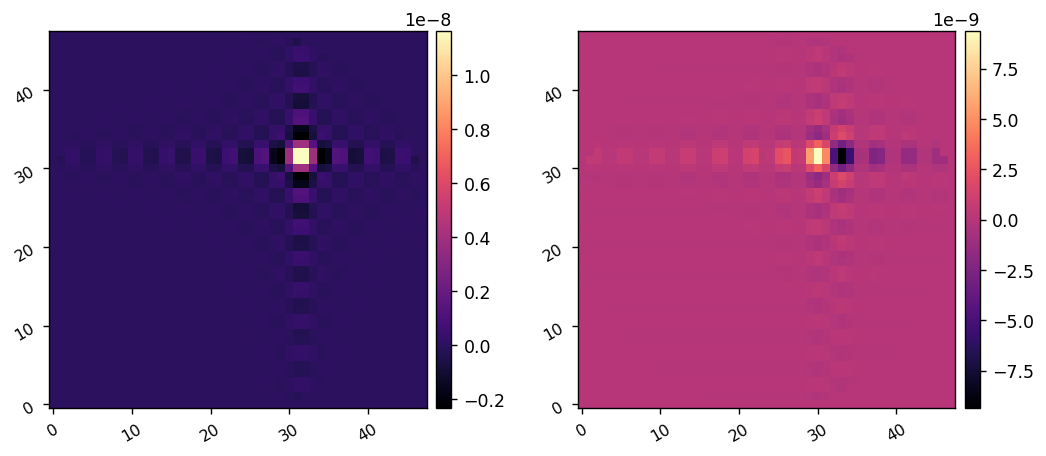

In [6]:
reload(pwp)

Npairs = 2
probe_amp = 0.025*sys.wavelength_c.value
probe_radius = 12
probe_offset = (8,8)

probes = pwp.create_sinc_probes(Npairs, Nact, sys.dm_mask, probe_amp, probe_radius, probe_offset, display=True)


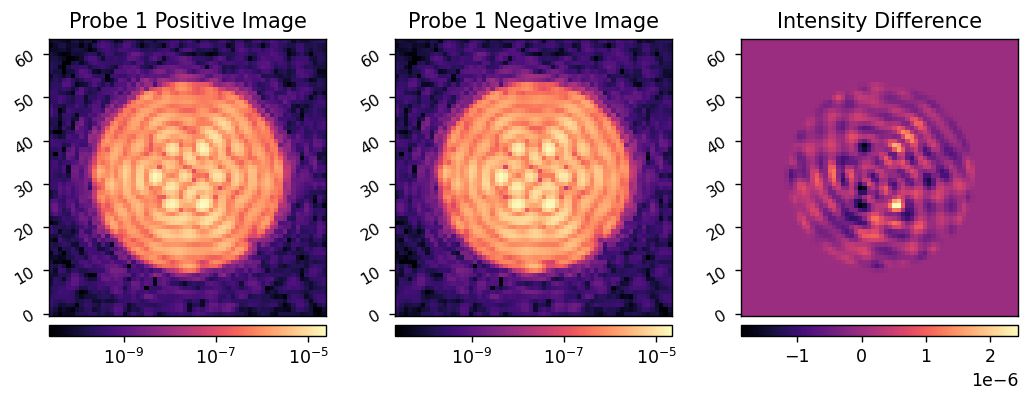

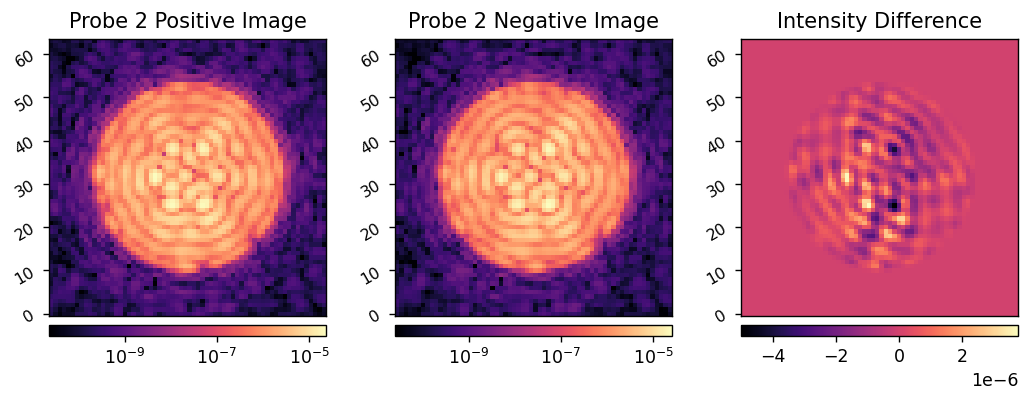

Hinv.shape (436, 2616)
Hinv.shape (872, 2616)


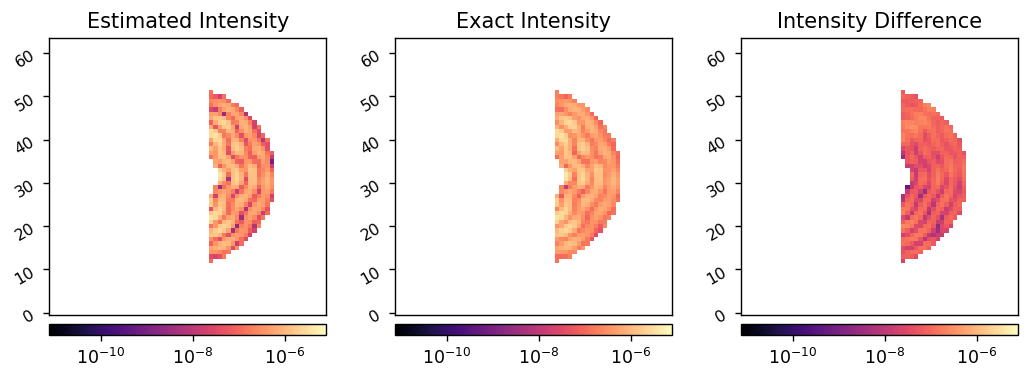

In [11]:
reload(pwp)

sys.reset_dms()
E_est = pwp.run_pwp_broad(sys, wavelengths, probes, dh_mask, use='j', jacobian=jac/2, rcond=1e-2, display=True)
# E_est = pwp.run_pwp_broad(sys, wavelengths, probes, dh_mask, use='m', model=sys, rcond=1e-14, display=True)

I_est = (np.abs(E_est)**2).sum(axis=0)/nwaves
diff = abs(ref_psf*dh_mask - I_est)

vmin = ref_psf.max()/1e6
vmax = ref_psf.max()
misc.myimshow3(I_est, 
               ref_psf*dh_mask, diff,
               'Estimated Intensity', 'Exact Intensity', 'Intensity Difference',
               lognorm1=True, lognorm2=True, lognorm3=True,
               vmin1=vmin, vmin2=vmin, vmin3=vmin,
               vmax1=vmax, vmax2=vmax, vmax3=vmax,
              )

In [9]:
wavelengths

<Quantity [5.60625e-07, 5.75000e-07, 5.89375e-07] m>

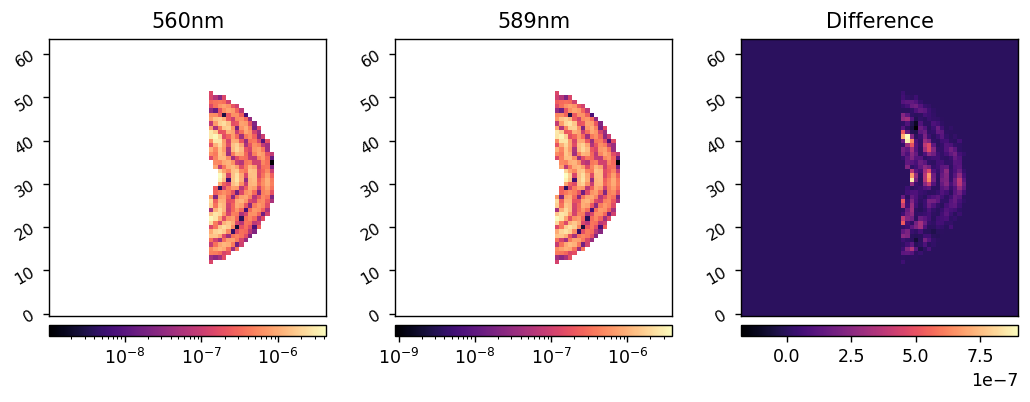

In [10]:
misc.myimshow3(np.abs(E_est[0])**2, np.abs(E_est[1])**2, np.abs(E_est[0])**2-np.abs(E_est[2])**2,
               '560nm', '589nm', 'Difference',
               lognorm1=True, lognorm2=True)

# Setup regularization scheme

In [22]:
reload(utils)
reg_fun = utils.beta_reg

reg_conds = np.array([[0, 15, 25, 35, 40, 45, 55, 65, 70, 75, 80, 85, 90, 95, 100, 110, 115, 125],
                      [0, -2, -1, -4, -1, -2, -1, -4, 0, -1, -2, 0, -1, -3, 0, -1, -2, -4]]) 

# Run EFC with perfect model

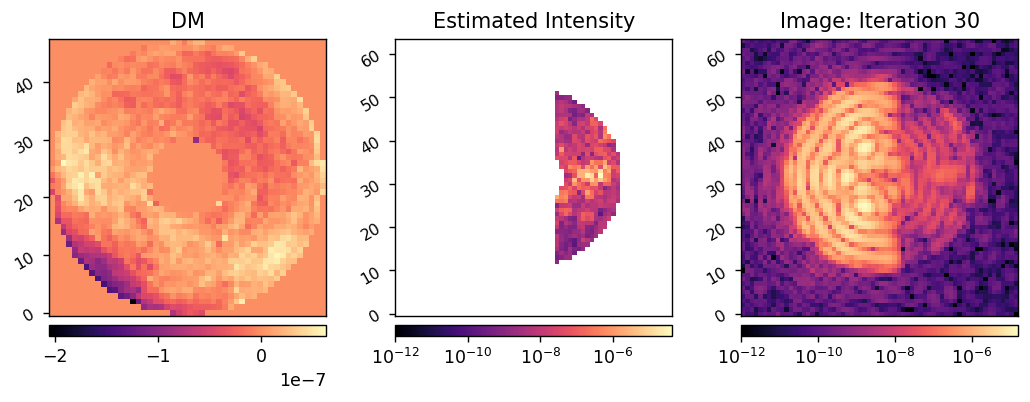

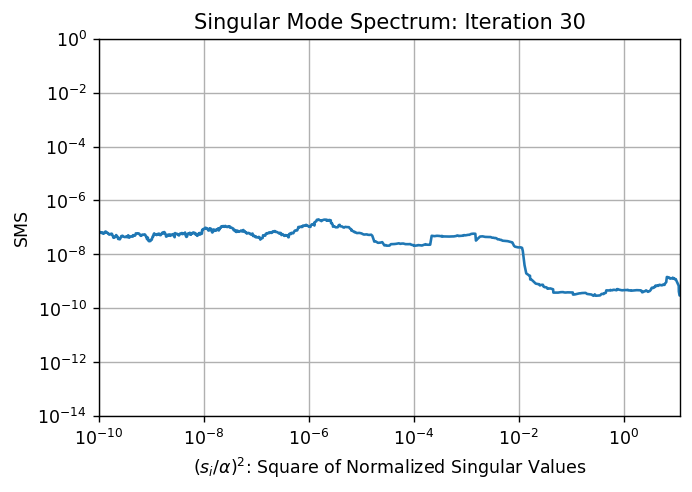

EFC completed in 451.335 sec.


In [25]:
reload(efc)
reload(utils)

sys.reset_dms()

commands, est_efields, images = efc.run_efc_pwp(sys,
                                                wavelengths,
                                                probes,
                                                jac,
                                                reg_fun,
                                                reg_conds,
                                                 dh_mask, 
                                                 Imax_unocc,
                                                 iterations=30, 
                                                 display_current=True, 
        #                                           display_all=True,
                                                 plot_sms=True)